# Construct Budget Plots

A Budget plot was constructed for the analysis of the carbon dioxide (CO2) consuming and producing reactions in the Bundle Sheat cell in the previously constructed Maize C4 model

## Imports

In [1]:
from cobra.io import read_sbml_model
from cobra import flux_analysis
import pandas as pd
from model_functions import *

## Reading the models and applying maintenance and Rubisco constrains

In [3]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[B]_Maize_biomass_tx'

# Setting up Rubisco carboxylase/oxygenase ratio in C4 model (added by Lisa)
#set_fixed_flux_ratio({'[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3,'[M]_RXN_961_p':1}, c4_model)
set_fixed_flux_ratio({'[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':10,'[B]_RXN_961_p':1}, c4_model)

def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

Restricted license - for non-production use only - expires 2026-11-23


No objective coefficients in model. Unclear what should be optimized


In [4]:
"""
C4 specific constrains
"""

#CONSTRAINT: No CO2 uptake in bundle sheat cells due to suberin layer in cell membranes
set_bounds("[B]_CO2_tx", (0.,0.), c4_model)

#Force C4 cycle: Block Rubisco carboxylase/oxygenase in Mesophyll
set_bounds('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p', (0, 0), c4_model)
set_bounds('[M]_RXN_961_p', (0, 0), c4_model)

#Force NADP-ME decarboxylation pathway: Block all other decarboxylation reactions except NADP_ME in the plastid
set_fixed_flux("[B]_PEPCARBOXYKIN_RXN_c", 0, c4_model)
set_fixed_flux("[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m", 0, c4_model)
set_fixed_flux("[B]_MALIC_NADP_RXN_c", 0, c4_model)

#Force NADP-ME decarboxylation pathways: make alternative decarboxylation routes irreversible
set_bounds('[B]_CARBAMATE_KINASE_RXN_p', (0, 1000), c4_model)
set_bounds('[M]_CARBAMATE_KINASE_RXN_p', (0, 1000), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_m', (0, 1000), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_m', (0, 1000), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_c', (0, 1000), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_c', (0, 1000), c4_model)

set_bounds('[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 1000), c4_model)
set_bounds('[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 1000), c4_model)

#Fix malate transport
set_bounds('[B]_OAA_MAL_pc', (0, 1000), c4_model)

set_bounds('[B]_PYRUVATE_pc', (0, 0), c4_model)

set_bounds('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c', (0, 0), c4_model)

In [16]:
c4_model.metabolites

[<Metabolite [M]_UREA_m at 0x7f5017b71180>,
 <Metabolite [B]_UREA_m at 0x7f5017b73580>,
 <Metabolite [M]_VAL_c at 0x7f5017b733a0>,
 <Metabolite [B]_VAL_c at 0x7f5017b72f50>,
 <Metabolite [M]_sVAL_b at 0x7f5017b736a0>,
 <Metabolite [B]_sVAL_b at 0x7f5017b73460>,
 <Metabolite [M]_GLYCEROL_3P_c at 0x7f5017b73490>,
 <Metabolite [B]_GLYCEROL_3P_c at 0x7f5017b73340>,
 <Metabolite [M]_VAL_m at 0x7f5017b731f0>,
 <Metabolite [B]_VAL_m at 0x7f5017b73220>,
 <Metabolite [M]_aDCDP_p at 0x7f5017b73250>,
 <Metabolite [B]_aDCDP_p at 0x7f5017b731c0>,
 <Metabolite [M]_N_5_PHOSPHORIBOSYL_ANTHRANILATE_p at 0x7f5017b73280>,
 <Metabolite [B]_N_5_PHOSPHORIBOSYL_ANTHRANILATE_p at 0x7f5017b732b0>,
 <Metabolite [M]_UREA_c at 0x7f5017b730d0>,
 <Metabolite [B]_UREA_c at 0x7f5017b73100>,
 <Metabolite [M]_ACETOACETATE_c at 0x7f5017b73130>,
 <Metabolite [B]_ACETOACETATE_c at 0x7f5017b730a0>,
 <Metabolite [M]_CARBOXYPHENYLAMINO_DEOXYRIBULOSE_P_p at 0x7f5017b72830>,
 <Metabolite [B]_CARBOXYPHENYLAMINO_DEOXYRIBULOSE_P_

In [5]:
c4_model.reactions.get_by_id('[B]_AGAT_x')

Reaction identifier,[B]_AGAT_x
Name,Glycine:oxaloacetate aminotransferase
Memory address,0x01a9aa95c708
Stoichiometry,[B]_GLYOX_x + [B]_L_ASPARTATE_x <=> [B]_GLY_x + [B]_OXALACETIC_ACID_x C2H1O3 + C4H6N1O4 <=> C2H5N1O2 + C4H2O5
GPR,
Lower bound,-1000.0
Upper bound,1000.0


## Using pFBA

In [5]:
"""
Function to perform the simulation: We will end with a pandas dataframe that we will use to construct the plots 
"""


def c4_simulation(light, N, c4_model):
    ##C4
    with c4_model:
        #Light Uptale constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        m_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        bs_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        #FBA
        print(f'Maize C4 FBA: {c4_model.summary()}')
        #pFBA
        solution = flux_analysis.pfba(c4_model)
        sum_of_flux = solution.fluxes.abs().sum()
        solution_frame=solution.to_frame()
        return solution_frame

#Definig limiting constrains: max of 100 μmol "light" uptake and 0.2 μmol nitrogen uptake
solution_frame=c4_simulation(1000, 10, c4_model)

Maize C4 FBA: Objective
1.0 [B]_Maize_biomass_tx = 0.1036381814901062

Uptake
------
          Metabolite       Reaction   Flux  C-Number C-Flux
         [B]_WATER_e     [B]_H2O_tx  68.32         0  0.00%
       [B]_NITRATE_e [B]_Nitrate_tx  5.239         0  0.00%
            [B]_Pi_e      [B]_Pi_tx 0.1131         0  0.00%
       [B]_SULFATE_e     [B]_SO4_tx 0.1496         0  0.00%
[M]_CARBON_DIOXIDE_e     [M]_CO2_tx  76.36         0  0.00%
        [M]_Photon_e  [M]_Photon_tx   1000         0  0.00%

Secretion
---------
           Metabolite  Reaction   Flux  C-Number C-Flux
[M]_OXYGEN_MOLECULE_e [M]_O2_tx -90.05         0  0.00%



## Preparing data and plotting

For the presented Budget plot we searched for CO2 consuming and producing reactions in the BS cell in the C4 model. Following this logic, transport reactions of CO2 were not considered, and so we expect the flux through consuming reactions to be equal to producing reactions.

In [28]:
#Defining the list of metabolites to search
budget_metabolites = []

#Defining the compartments within the model
compartment = ["_c", "_m", "_p", "_x", "_e", "tx"]

#Searching for the metabolites in the model - Searching for CO2 in the BS cell
for met in c4_model.metabolites.query("]_TYR_p"):
    if met.id[:3] == "[B]":
        budget_metabolites.append(met)

budget_metabolites

[<Metabolite [B]_TYR_p at 0x7f5017b70e80>]

In [19]:
"""
Define consuming and producing reactions
"""

#Defining list of reactions producing and consuming the metabolite
consumers = []
producers = []

#Add reactions to respective list and exclude transport reactions
for met in budget_metabolites:
    for reaction in c4_model.reactions:
        if met in reaction.reactants and reaction.id[-2:] in compartment:
            consumers.append(reaction.id)
        elif met in reaction.products and reaction.id[-2:] in compartment:
            producers.append(reaction.id)
consumers

[]

In [20]:
"""
Correct consumption/production with regards to directionality
"""

#Get flux values from the simulation for metabolite consuming/producing reactions
producers_df = solution_frame.loc[producers,:]
consumers_df = solution_frame.loc[consumers,:]

#Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)


#Add reactions to correct list
consumers.extend(negative_producers)
producers.extend(negative_consumers)

#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

for item in negative_producers:
    producers = remove_items(producers, item)

for item in negative_consumers:
    consumers = remove_items(consumers, item)


In [21]:
"""
Get producing reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
producers_df = solution_frame.loc[producers,:]
print(producers_df)
#Make all values positive (disregard directionality)
producers_df["fluxes"] = producers_df["fluxes"].abs()
#Remove reactions with zero flux
producers_df = producers_df[(producers_df.T != 0).all()]
#producers_df

                                       fluxes  reduced_costs
[B]_RXN_5682_p                       0.069039           -2.0
[B]_TYROSINE_AMINOTRANSFERASE_RXN_p  0.000000           -2.0


In [22]:
"""
Get consuming reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
consumers_df = solution_frame.loc[consumers,:]
#Make all values positive (disregard directionality)
consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
#Remove reactions with zero flux
consumers_df = consumers_df[(consumers_df.T != 0).all()]
consumers_df


,fluxes,reduced_costs


In [23]:
"""
Fluxes in consumption and production should be equal
"""

#Sum the flux values
print("Sum of consumer fluxes: {}".format(consumers_df ["fluxes"].sum(axis=0)))
print("Sum of producer fluxes: {}".format(producers_df ["fluxes"].sum(axis=0)))

Sum of consumer fluxes: 0.0
Sum of producer fluxes: 0.06903881732025609


As expected, the sum of the fluxes of the CO2 consuming reactions is equal to the sum of CO2 producing reactions in the bundle sheat cell.

In [24]:
"""
Concatenate producer and consumer dataframes
"""

producers_df["Status"] = "Producer"
consumers_df["Status"] = "Consumer"

frame = [producers_df, consumers_df]

all_reactions = pd.concat(frame)

all_reactions["label"] = all_reactions.index

all_reactions

,fluxes,reduced_costs,Status,label
[B]_RXN_5682_p,0.069039,-2.0,Producer,[B]_RXN_5682_p


In [25]:
"""
Pick the colors - using random for color selection and using set.seed for reproducibility
"""

import random
import matplotlib.pyplot as plt


#Defining the nº of colors
number_of_colors = len(all_reactions.index)

#Getting a list of colors
random.seed(177)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

#Getting list of reactions
reaction_list = list(all_reactions.index)

#Build color dictionary
color_dict = {}
for i in range(len(reaction_list)):
    color_dict[reaction_list[i]] = color[i]



label,[B]_RXN_5682_p
Status,
Producer,0.069039


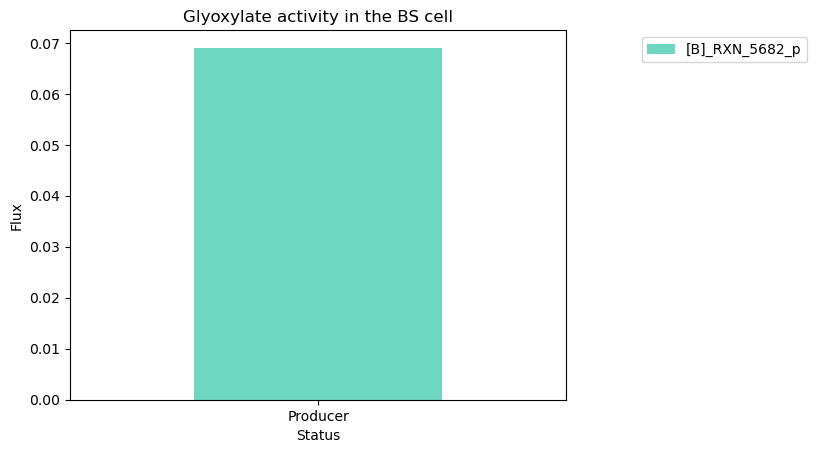

In [26]:
"""
Plot the pivot table and barplot
"""


chart = all_reactions.pivot_table(index="Status", columns="label", values="fluxes")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
plt.title("Glyoxylate activity in the BS cell" )
figsize = [11, 14] #To prevent the cropping of the image
#plt.savefig('Budget_tests.svg', format='svg', bbox_inches = 'tight', dpi=600) #Line to save the image
chart




In the budget plot we can observe that the majority of CO2 in the bundle sheath cell is produced by the "MALIC_NADP_RXN_p" reaction, which is the NADP - malic enzyme reaction. This is the main decarboxylation pathway in C4 photosynthesis in maize, and we privelieged it other decarboxylation pathways in our approach. 

Consumption of CO2, as expected, occurs through the carboxylase activity of Rubisco, represented throught the "RIBULOSE_BIPHOSPHATE_CARBOXYLASE_RXN_p"